# Corporate Resilience Project - AFFECTED_RATIO & Baseline Regression
## Notebook 5: Calculate Hsu et al. (2018) Metrics and Run Analysis


**What this notebook does:**
1.  Loads BOTH Compustat files (companies 1-10,000 and 10,001+)
2.  Reshapes from WIDE to LONG format
3. Merges with TRI-CRSP matched data
4. Calculates AFFECTED_RATIO following Hsu et al. (2018)
5.  Runs regression: ΔROA ~ AFFECTED_RATIO + controls
6.  Generates results table and visualizations



## Setup: Install Packages and Import Libraries

In [33]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
from pathlib import Path
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Define paths
BASE_PATH = Path('/content/drive/MyDrive/Paper1_Dataset')
PROCESSED_PATH = BASE_PATH / 'processed'

print("="*80)
print("NOTEBOOK 5: BASELINE REGRESSION ANALYSIS")
print("="*80)
print("✓ Libraries loaded")
print("="*80)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
NOTEBOOK 5: BASELINE REGRESSION ANALYSIS
✓ Libraries loaded


In [34]:
print("\n" + "="*80)
print("LOADING AND PREPARING DATA")
print("="*80)

# Load facility-level data with disasters
facility_data = pd.read_parquet(PROCESSED_PATH / 'analysis_dataset_complete.parquet')

print(f"\n1. Facility-level data loaded:")
print(f"   Total facility-years: {len(facility_data):,}")
print(f"   With PERMNO: {facility_data['PERMNO'].notna().sum():,}")
print(f"   With disasters: {(facility_data['num_disasters'] > 0).sum():,}")

# Keep only matched facilities
matched = facility_data[facility_data['PERMNO'].notna()].copy()

# Aggregate to company-year level
print(f"\n2. Aggregating to company-year level...")

company_year = matched.groupby(['PERMNO', 'DATA_YEAR']).agg({
    'TRIFD': 'count',  # total facilities
    'num_disasters': 'sum',  # total disasters
    'disaster_exposed': 'sum',  # exposed facilities
    'TICKER': 'first',
}).reset_index()

company_year.columns = ['PERMNO', 'YEAR', 'total_facilities',
                        'num_disasters', 'exposed_facilities', 'TICKER']

# Calculate key variables
company_year['AFFECTED_RATIO'] = company_year['exposed_facilities'] / company_year['total_facilities']
company_year['DISASTER'] = (company_year['num_disasters'] > 0).astype(int)

print(f"   ✓ Company-year panel: {len(company_year):,} observations")
print(f"   ✓ Unique companies: {company_year['PERMNO'].nunique():,}")
print(f"   ✓ Years: {company_year['YEAR'].min()}-{company_year['YEAR'].max()}")
print(f"   ✓ With disasters: {company_year['DISASTER'].sum():,} ({company_year['DISASTER'].mean()*100:.1f}%)")
print(f"   ✓ Mean AFFECTED_RATIO: {company_year['AFFECTED_RATIO'].mean():.3f}")

print("="*80)



LOADING AND PREPARING DATA

1. Facility-level data loaded:
   Total facility-years: 1,141,457
   With PERMNO: 244,872
   With disasters: 360,974

2. Aggregating to company-year level...
   ✓ Company-year panel: 11,596 observations
   ✓ Unique companies: 1,016
   ✓ Years: 2009-2023
   ✓ With disasters: 5,593 (48.2%)
   ✓ Mean AFFECTED_RATIO: 0.283


In [37]:
print("\n" + "="*80)
print("LOADING CAPITAL IQ FINANCIAL DATA")
print("="*80)

# ============================================================================
# Load Capital IQ Excel files and reshape from WIDE to LONG format
# ============================================================================

COMPUSTAT_PATH = BASE_PATH / 'compustat'

def load_and_reshape_capital_iq(file_path, debug=True):
    """Load Capital IQ Excel and reshape from wide to long format.

    FIXED: Now uses header=7 instead of skiprows to correctly identify the header row.
    """
    import re

    # MAIN FIX: Use header=7 to correctly identify the column headers
    # The Capital IQ file has headers at row 7 (0-indexed)
    df = pd.read_excel(file_path, header=7)

    # Clean column names
    df.columns = [str(c).strip() for c in df.columns]

    if debug:
        print(f"   Columns found: {len(df.columns)}")
        print(f"   Sample columns: {df.columns[:5].tolist()}")
        print(f"   Rows in file: {len(df)}")

    # Find company name column
    company_col = None
    for c in df.columns:
        if 'company name' in c.lower() or c.lower() == 'company':
            company_col = c
            break

    if company_col is None:
        # Try first column if it looks like names
        first_col = df.columns[0]
        if df[first_col].dtype == object:
            company_col = first_col
            if debug:
                print(f"   Using first column as company: '{company_col}'")

    if debug and company_col:
        non_null = df[company_col].notna().sum()
        print(f"   Company column: '{company_col}' ({non_null} non-null values)")

    # Extract ticker from "Exchange:Ticker" column
    ticker_col = None
    for c in df.columns:
        if 'ticker' in c.lower() or 'exchange' in c.lower():
            ticker_col = c
            break

    if ticker_col and 'Exchange:Ticker' in df.columns:
        df['TICKER'] = df['Exchange:Ticker'].str.extract(r':(\w+)$')[0]
        df.loc[df['TICKER'].isna(), 'TICKER'] = df.loc[df['TICKER'].isna(), 'Exchange:Ticker']
    elif ticker_col:
        df['TICKER'] = df[ticker_col].astype(str).str.extract(r':?(\w+)$')[0]
    else:
        df['TICKER'] = None

    # Identify the financial metrics and years
    metrics = {
        'Total Assets': 'TOTAL_ASSETS',
        'Total Debt': 'TOTAL_DEBT',
        'Net Income': 'NET_INCOME',
        'Total Revenue': 'TOTAL_REVENUE',
        'Cash from Ops': 'CASH_FROM_OPS',
        'Cash from Ops.': 'CASH_FROM_OPS',
        'Capital Expenditure': 'CAPITAL_EXPENDITURE'
    }

    years = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]

    # Find columns for each metric-year combination
    records = []

    # Build column mapping
    col_mapping = {}
    for col in df.columns:
        col_lower = col.lower()
        for orig_metric, new_metric in metrics.items():
            if orig_metric.lower() in col_lower:
                # Extract year from column name
                year_match = re.search(r'(?:CY|FY)?\s*(\d{4})', col)
                if year_match:
                    year = int(year_match.group(1))
                    if year in years:
                        col_mapping[(new_metric, year)] = col

    if debug:
        print(f"   Metric-year columns found: {len(col_mapping)}")

    for idx, row in df.iterrows():
        if company_col is None:
            continue

        company_name = row.get(company_col, '')
        ticker = row.get('TICKER', '')

        # Skip empty rows
        if pd.isna(company_name) or str(company_name).strip() == '':
            continue

        # Skip header-like rows
        if str(company_name).lower() in ['company name', 'company', 'name']:
            continue

        for year in years:
            record = {
                'COMPANY_NAME': company_name,
                'TICKER': ticker,
                'YEAR': year
            }

            has_any_value = False
            for new_metric in ['TOTAL_ASSETS', 'TOTAL_DEBT', 'NET_INCOME',
                              'TOTAL_REVENUE', 'CASH_FROM_OPS', 'CAPITAL_EXPENDITURE']:
                col_key = (new_metric, year)
                if col_key in col_mapping:
                    value = row[col_mapping[col_key]]
                    # Clean the value
                    if isinstance(value, str):
                        value = value.strip()
                        if value.startswith('(') and value.endswith(')'):
                            value = '-' + value[1:-1]
                        value = value.replace(',', '').replace('$', '').replace(' ', '')
                        if value == '-' or value == '' or value.lower() == 'nm' or value.lower() == 'na':
                            value = np.nan
                        else:
                            try:
                                value = float(value)
                                has_any_value = True
                            except:
                                value = np.nan
                    elif pd.notna(value):
                        has_any_value = True
                    record[new_metric] = value
                else:
                    record[new_metric] = np.nan

            # Only add record if it has at least one financial value
            if has_any_value:
                records.append(record)

    result_df = pd.DataFrame(records)
    if debug:
        print(f"   Records created: {len(result_df)}")

    return result_df

def standardize_company_name(name):
    """Standardize company name for matching (same as TRI-CRSP matching)."""
    import re
    if pd.isna(name) or name == '':
        return ''
    name = str(name).upper().strip()
    name = re.sub(r'[,\-/]', ' ', name)
    name = re.sub(r'\s+&\s+', ' AND ', name)
    # Remove legal suffixes
    for suffix in [r'\bINCORPORATED\b', r'\bINC\.?\b', r'\bCORPORATION\b', r'\bCORP\.?\b',
                   r'\bCOMPANY\b', r'\bCO\.?\b', r'\bLIMITED\b', r'\bLTD\.?\b',
                   r'\bLLC\b', r'\bL\.?L\.?C\.?\b', r'\bLP\b', r'\bLLP\b', r'\bPLC\b']:
        name = re.sub(suffix, '', name)
    name = re.sub(r'[^A-Z0-9\s]', '', name)
    name = re.sub(r'\s+', ' ', name).strip()
    return name

# Load both Capital IQ files
financial = None
try:
    file1 = COMPUSTAT_PATH / 'Company Screening Report (3).xls'
    file2 = COMPUSTAT_PATH / 'Company Screening Report (4).xls'

    print(f"\n1. Loading Capital IQ files...")

    dfs = []
    for f in [file1, file2]:
        if f.exists():
            print(f"\n   Loading: {f.name}")
            df_temp = load_and_reshape_capital_iq(f, debug=True)
            if len(df_temp) > 0:
                dfs.append(df_temp)
                print(f"   → {len(df_temp):,} records loaded successfully")
            else:
                print(f"   → 0 records (file may have different format)")
        else:
            print(f"   File not found: {f.name}")

    if dfs and sum(len(d) for d in dfs) > 0:
        financial_long = pd.concat(dfs, ignore_index=True)
        print(f"\n2. Combined data: {len(financial_long):,} company-year records")

        # Check which financial columns exist before dropping NAs
        fin_cols = ['TOTAL_ASSETS', 'TOTAL_DEBT', 'NET_INCOME', 'TOTAL_REVENUE',
                   'CASH_FROM_OPS', 'CAPITAL_EXPENDITURE']
        existing_fin_cols = [c for c in fin_cols if c in financial_long.columns]

        if existing_fin_cols:
            financial_long = financial_long.dropna(subset=existing_fin_cols, how='all')
            print(f"   After removing empty rows: {len(financial_long):,}")

            # Clean tickers and company names
            financial_long['TICKER'] = financial_long['TICKER'].astype(str).str.upper().str.strip()
            financial_long['TICKER'] = financial_long['TICKER'].replace(['NAN', 'NONE', ''], np.nan)
            financial_long['COMPANY_NAME_STD'] = financial_long['COMPANY_NAME'].apply(standardize_company_name)

            # Load CRSP data
            print(f"\n3. Matching with CRSP (ticker + company name)...")
            crsp = pd.read_parquet(PROCESSED_PATH / 'crsp_companies.parquet')
            crsp['TICKER'] = crsp['TICKER'].str.upper().str.strip()
            if 'COMNAM' in crsp.columns:
                crsp['COMNAM_STD'] = crsp['COMNAM'].apply(standardize_company_name)
            elif 'COMNAM_STD' not in crsp.columns:
                crsp['COMNAM_STD'] = ''

            # Check CRSP ticker coverage
            crsp_with_ticker = crsp[crsp['TICKER'].notna() & (crsp['TICKER'] != '')]
            print(f"   CRSP companies with ticker: {len(crsp_with_ticker):,} / {len(crsp):,}")

            # STEP A: Match by TICKER first
            print(f"\n   Step A: Matching by ticker...")
            financial_long = financial_long.merge(
                crsp[['TICKER', 'PERMNO']].drop_duplicates(),
                on='TICKER',
                how='left'
            )
            ticker_matched = financial_long['PERMNO'].notna().sum()
            print(f"   → Matched by ticker: {ticker_matched:,}")

            # STEP B: For unmatched, try matching by company name
            unmatched_mask = financial_long['PERMNO'].isna()
            unmatched_count = unmatched_mask.sum()

            if unmatched_count > 0:
                print(f"\n   Step B: Matching unmatched by company name ({unmatched_count:,} records)...")

                unmatched_names = financial_long.loc[unmatched_mask, 'COMPANY_NAME_STD'].unique()
                print(f"   → Unique unmatched companies: {len(unmatched_names):,}")

                crsp_name_lookup = crsp[['COMNAM_STD', 'PERMNO']].drop_duplicates(subset=['COMNAM_STD'])
                crsp_name_lookup = crsp_name_lookup[crsp_name_lookup['COMNAM_STD'].notna() & (crsp_name_lookup['COMNAM_STD'] != '')]

                name_matches = pd.DataFrame({'COMPANY_NAME_STD': unmatched_names})
                name_matches = name_matches.merge(
                    crsp_name_lookup.rename(columns={'COMNAM_STD': 'COMPANY_NAME_STD', 'PERMNO': 'PERMNO_NAME'}),
                    on='COMPANY_NAME_STD',
                    how='left'
                )

                exact_name_matched = name_matches['PERMNO_NAME'].notna().sum()
                print(f"   → Exact name matches: {exact_name_matched:,}")

                if exact_name_matched > 0:
                    name_match_dict = name_matches.set_index('COMPANY_NAME_STD')['PERMNO_NAME'].dropna().to_dict()
                    for idx in financial_long[unmatched_mask].index:
                        company_name_std = financial_long.loc[idx, 'COMPANY_NAME_STD']
                        if company_name_std in name_match_dict:
                            financial_long.loc[idx, 'PERMNO'] = name_match_dict[company_name_std]

            total_matched = financial_long['PERMNO'].notna().sum()
            print(f"\n   Total matched: {total_matched:,} ({total_matched/len(financial_long)*100:.1f}%)")
            print(f"   → By ticker: {ticker_matched:,}")
            print(f"   → By name: {total_matched - ticker_matched:,}")

            # Keep only matched records
            financial = financial_long[financial_long['PERMNO'].notna()].copy()

            if len(financial) > 0:
                print(f"\n4. Final financial data:")
                print(f"   Company-years: {len(financial):,}")
                print(f"   Unique companies: {financial['PERMNO'].nunique():,}")
                print(f"   Years: {financial['YEAR'].min()}-{financial['YEAR'].max()}")
                print(f"   With TOTAL_ASSETS: {financial['TOTAL_ASSETS'].notna().sum():,}")
                print(f"   With NET_INCOME: {financial['NET_INCOME'].notna().sum():,}")

                # Save for future use
                output_file = PROCESSED_PATH / 'company_year_panel_with_affected_ratio.parquet'
                financial.to_parquet(output_file, index=False)
                print(f"\n   Saved: {output_file}")
            else:
                print("\n   No matched financial data found")
                financial = None
        else:
            print(f"   No financial columns found in data!")
            financial = None
    else:
        print("\n   No data loaded from Capital IQ files!")
        print("   Please check that the Excel files exist and have the expected format.")
        financial = None

except Exception as e:
    print(f"\n   Error loading financial data: {e}")
    import traceback
    traceback.print_exc()
    financial = None

print("="*80)


LOADING CAPITAL IQ FINANCIAL DATA

1. Loading Capital IQ files...

   Loading: Company Screening Report (3).xls
   Columns found: 52
   Sample columns: ['Company Name', 'Exchange:Ticker', 'Geographic Locations', 'Company Type', 'Total Assets [CY 2016] ($USDmm, Historical rate)']
   Rows in file: 10000
   Company column: 'Company Name' (10000 non-null values)
   Metric-year columns found: 48
   Records created: 22900
   → 22,900 records loaded successfully

   Loading: Company Screening Report (4).xls
   Columns found: 52
   Sample columns: ['Company Name', 'Exchange:Ticker', 'Geographic Locations', 'Company Type', 'Total Assets [CY 2016] ($USDmm, Historical rate)']
   Rows in file: 8076
   Company column: 'Company Name' (8076 non-null values)
   Metric-year columns found: 48
   Records created: 17659
   → 17,659 records loaded successfully

2. Combined data: 40,559 company-year records
   After removing empty rows: 40,559

3. Matching with CRSP (ticker + company name)...
   CRSP compa

In [38]:
print("\n" + "="*80)
print("MERGING DISASTER EXPOSURE WITH FINANCIAL DATA")
print("="*80)

if financial is not None:
    # Merge
    analysis_data = company_year.merge(
        financial,
        on=['PERMNO', 'YEAR'],
        how='inner'
    )

    print(f"\n✓ Merge complete:")
    print(f"  Total observations: {len(analysis_data):,}")
    print(f"  Unique companies: {analysis_data['PERMNO'].nunique():,}")
    print(f"  Years: {analysis_data['YEAR'].min()}-{analysis_data['YEAR'].max()}")

    # Calculate ROA
    analysis_data['ROA'] = analysis_data['NET_INCOME'] / analysis_data['TOTAL_ASSETS']

    # Calculate control variables
    analysis_data['LOG_ASSETS'] = np.log(analysis_data['TOTAL_ASSETS'].replace(0, np.nan))
    analysis_data['LEVERAGE'] = analysis_data['TOTAL_DEBT'] / analysis_data['TOTAL_ASSETS']
    analysis_data['REVENUE_GROWTH'] = analysis_data.groupby('PERMNO')['TOTAL_REVENUE'].pct_change()

    print(f"\n✓ Variables created:")
    print(f"  ROA: {analysis_data['ROA'].notna().sum():,} observations")
    print(f"  LOG_ASSETS: {analysis_data['LOG_ASSETS'].notna().sum():,}")
    print(f"  LEVERAGE: {analysis_data['LEVERAGE'].notna().sum():,}")

else:
    print("⚠️  No financial data - using disaster data only")
    analysis_data = company_year.copy()

print("="*80)



MERGING DISASTER EXPOSURE WITH FINANCIAL DATA

✓ Merge complete:
  Total observations: 2,453
  Unique companies: 332
  Years: 2016-2023

✓ Variables created:
  ROA: 2,438 observations
  LOG_ASSETS: 2,438
  LEVERAGE: 2,438


In [39]:
# ============================================================================
# CELL 5: DESCRIPTIVE STATISTICS
# ============================================================================
print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS")
print("="*80)

# Summary statistics
print("\n1. KEY VARIABLES:")
print("-" * 80)

key_vars = ['AFFECTED_RATIO', 'DISASTER', 'num_disasters', 'total_facilities']
if 'ROA' in analysis_data.columns:
    key_vars.extend(['ROA', 'TOTAL_ASSETS', 'LEVERAGE'])

desc = analysis_data[key_vars].describe()
print(desc.to_string())

# Disaster exposure distribution
print("\n2. DISASTER EXPOSURE DISTRIBUTION:")
print("-" * 80)
print(f"Companies with 0% facilities affected: {(analysis_data['AFFECTED_RATIO'] == 0).sum():,} ({(analysis_data['AFFECTED_RATIO'] == 0).mean()*100:.1f}%)")
print(f"Companies with 1-25% affected: {((analysis_data['AFFECTED_RATIO'] > 0) & (analysis_data['AFFECTED_RATIO'] <= 0.25)).sum():,}")
print(f"Companies with 26-50% affected: {((analysis_data['AFFECTED_RATIO'] > 0.25) & (analysis_data['AFFECTED_RATIO'] <= 0.50)).sum():,}")
print(f"Companies with 51-75% affected: {((analysis_data['AFFECTED_RATIO'] > 0.50) & (analysis_data['AFFECTED_RATIO'] <= 0.75)).sum():,}")
print(f"Companies with 76-100% affected: {(analysis_data['AFFECTED_RATIO'] > 0.75).sum():,}")

print("="*80)


DESCRIPTIVE STATISTICS

1. KEY VARIABLES:
--------------------------------------------------------------------------------
       AFFECTED_RATIO     DISASTER  num_disasters  total_facilities          ROA   TOTAL_ASSETS     LEVERAGE
count     2453.000000  2453.000000    2453.000000       2453.000000  2438.000000    2438.000000  2438.000000
mean         0.245446     0.480636    2512.431309         32.588259     0.051460   18579.318825     0.308644
std          0.338170     0.499727   28864.920269        104.670375     0.086898   37468.647266     0.167538
min          0.000000     0.000000       0.000000          1.000000    -0.759072       0.352000     0.000000
25%          0.000000     0.000000       0.000000          3.000000     0.021292    1528.650000     0.203207
50%          0.000000     0.000000       0.000000          8.000000     0.050059    4877.350000     0.307220
75%          0.428571     1.000000      76.000000         24.000000     0.086136   18148.275000     0.405663
max 

In [40]:

# ============================================================================
# CELL 6: BASELINE REGRESSION
# ============================================================================
print("\n" + "="*80)
print("BASELINE REGRESSION: IMPACT ON ROA")
print("="*80)

if 'ROA' in analysis_data.columns:
    # Prepare regression data
    reg_data = analysis_data[['ROA', 'AFFECTED_RATIO', 'LOG_ASSETS', 'LEVERAGE',
                               'PERMNO', 'YEAR']].dropna()

    print(f"\nRegression sample:")
    print(f"  Observations: {len(reg_data):,}")
    print(f"  Companies: {reg_data['PERMNO'].nunique():,}")
    print(f"  Mean ROA: {reg_data['ROA'].mean():.4f}")
    print(f"  Mean AFFECTED_RATIO: {reg_data['AFFECTED_RATIO'].mean():.4f}")

    # Model 1: Simple OLS
    print("\n" + "-"*80)
    print("MODEL 1: Simple OLS")
    print("-"*80)

    model1 = smf.ols('ROA ~ AFFECTED_RATIO', data=reg_data).fit()
    print(model1.summary())

    # Model 2: With controls
    print("\n" + "-"*80)
    print("MODEL 2: With firm controls")
    print("-"*80)

    model2 = smf.ols('ROA ~ AFFECTED_RATIO + LOG_ASSETS + LEVERAGE', data=reg_data).fit()
    print(model2.summary())

    # Model 3: With fixed effects
    print("\n" + "-"*80)
    print("MODEL 3: With year fixed effects")
    print("-"*80)

    model3 = smf.ols('ROA ~ AFFECTED_RATIO + LOG_ASSETS + LEVERAGE + C(YEAR)',
                     data=reg_data).fit()
    print(model3.summary())

    # Save results
    results_summary = pd.DataFrame({
        'Model': ['(1) Simple', '(2) Controls', '(3) Year FE'],
        'Coefficient': [model1.params['AFFECTED_RATIO'],
                       model2.params['AFFECTED_RATIO'],
                       model3.params['AFFECTED_RATIO']],
        'Std Error': [model1.bse['AFFECTED_RATIO'],
                     model2.bse['AFFECTED_RATIO'],
                     model3.bse['AFFECTED_RATIO']],
        'P-value': [model1.pvalues['AFFECTED_RATIO'],
                   model2.pvalues['AFFECTED_RATIO'],
                   model3.pvalues['AFFECTED_RATIO']],
        'R-squared': [model1.rsquared, model2.rsquared, model3.rsquared],
        'N': [model1.nobs, model2.nobs, model3.nobs]
    })

    print("\n" + "="*80)
    print("RESULTS SUMMARY")
    print("="*80)
    print(results_summary.to_string(index=False))

    # Save to file
    results_file = PROCESSED_PATH / 'regression_results_baseline.csv'
    results_summary.to_csv(results_file, index=False)
    print(f"\n✓ Results saved: {results_file}")

else:
    print("⚠️  ROA variable not available - cannot run regression")
    print("   Need to merge with financial data first")

print("="*80)



BASELINE REGRESSION: IMPACT ON ROA

Regression sample:
  Observations: 2,438
  Companies: 332
  Mean ROA: 0.0515
  Mean AFFECTED_RATIO: 0.2448

--------------------------------------------------------------------------------
MODEL 1: Simple OLS
--------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1204
Date:                Wed, 10 Dec 2025   Prob (F-statistic):              0.729
Time:                        02:19:39   Log-Likelihood:                 2497.3
No. Observations:                2438   AIC:                            -4991.
Df Residuals:                    2436   BIC:                            -4979.
Df Model:                           1    

## Step 4: Load TRI-CRSP Matched Data

In [41]:

# ============================================================================
# CELL 7: ROBUSTNESS - DISASTER INTENSITY
# ============================================================================
print("\n" + "="*80)
print("ROBUSTNESS: DISASTER INTENSITY EFFECTS")
print("="*80)

if 'ROA' in analysis_data.columns:
    # Create intensity categories
    analysis_data['INTENSITY_LOW'] = ((analysis_data['AFFECTED_RATIO'] > 0) &
                                      (analysis_data['AFFECTED_RATIO'] <= 0.25)).astype(int)
    analysis_data['INTENSITY_MED'] = ((analysis_data['AFFECTED_RATIO'] > 0.25) &
                                      (analysis_data['AFFECTED_RATIO'] <= 0.50)).astype(int)
    analysis_data['INTENSITY_HIGH'] = (analysis_data['AFFECTED_RATIO'] > 0.50).astype(int)

    reg_data_intensity = analysis_data[['ROA', 'INTENSITY_LOW', 'INTENSITY_MED',
                                         'INTENSITY_HIGH', 'LOG_ASSETS', 'LEVERAGE',
                                         'YEAR']].dropna()

    print(f"\nSample sizes:")
    print(f"  Low intensity (1-25%): {reg_data_intensity['INTENSITY_LOW'].sum():,}")
    print(f"  Medium intensity (26-50%): {reg_data_intensity['INTENSITY_MED'].sum():,}")
    print(f"  High intensity (>50%): {reg_data_intensity['INTENSITY_HIGH'].sum():,}")

    model_intensity = smf.ols(
        'ROA ~ INTENSITY_LOW + INTENSITY_MED + INTENSITY_HIGH + LOG_ASSETS + LEVERAGE + C(YEAR)',
        data=reg_data_intensity
    ).fit()

    print("\n" + "-"*80)
    print("Intensity Effects (relative to no disaster):")
    print("-"*80)
    print(model_intensity.summary())

print("="*80)



ROBUSTNESS: DISASTER INTENSITY EFFECTS

Sample sizes:
  Low intensity (1-25%): 330
  Medium intensity (26-50%): 357
  High intensity (>50%): 483

--------------------------------------------------------------------------------
Intensity Effects (relative to no disaster):
--------------------------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                    ROA   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     11.78
Date:                Wed, 10 Dec 2025   Prob (F-statistic):           1.74e-23
Time:                        02:19:43   Log-Likelihood:                 2566.3
No. Observations:                2438   AIC:                            -5107.
Df Residuals:                    2425   BIC:                            -5031.
Df Model:     


CREATING VISUALIZATIONS
✓ Visualizations saved: /content/drive/MyDrive/Paper1_Dataset/processed/regression_visualizations.png


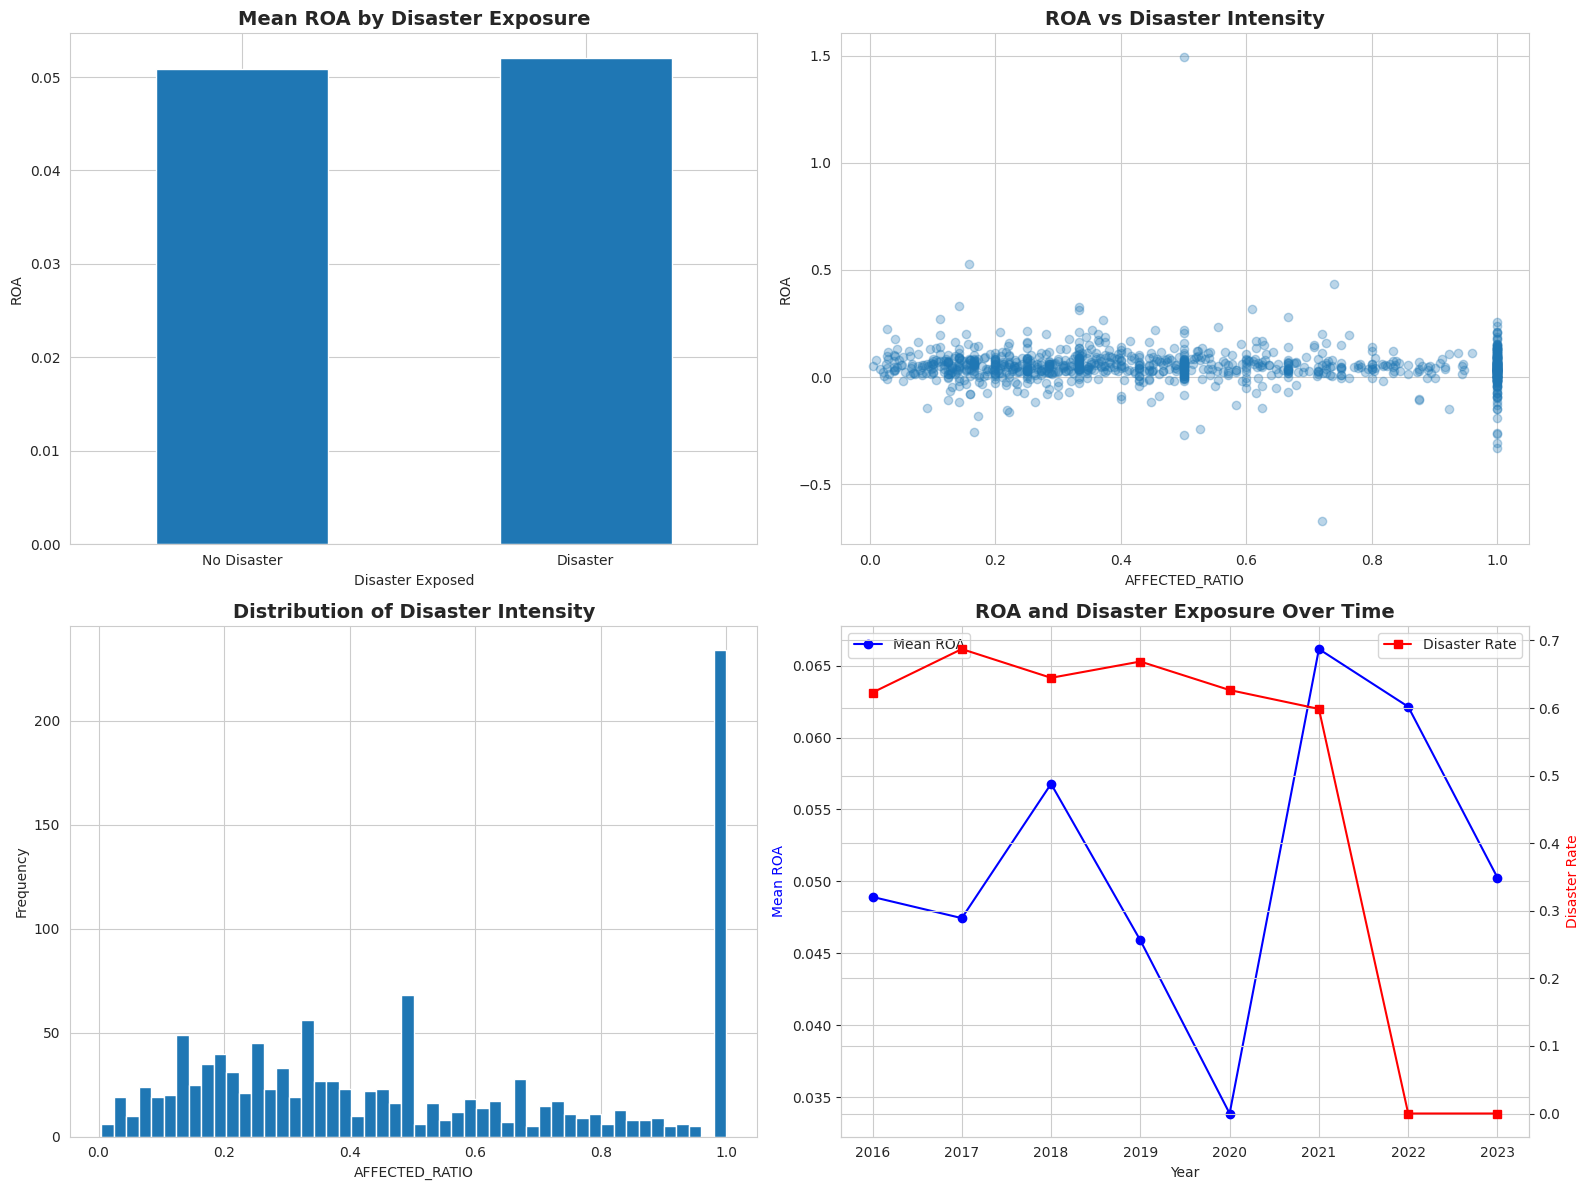

✅ BASELINE ANALYSIS COMPLETE!


In [42]:

# ============================================================================
# CELL 8: VISUALIZATION
# ============================================================================
print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

if 'ROA' in analysis_data.columns:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. ROA by disaster exposure
    ax1 = axes[0, 0]
    analysis_data.groupby('DISASTER')['ROA'].mean().plot(kind='bar', ax=ax1)
    ax1.set_title('Mean ROA by Disaster Exposure', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Disaster Exposed')
    ax1.set_ylabel('ROA')
    ax1.set_xticklabels(['No Disaster', 'Disaster'], rotation=0)

    # 2. ROA vs AFFECTED_RATIO scatter
    ax2 = axes[0, 1]
    sample = analysis_data[analysis_data['AFFECTED_RATIO'] > 0].sample(min(1000, len(analysis_data)))
    ax2.scatter(sample['AFFECTED_RATIO'], sample['ROA'], alpha=0.3)
    ax2.set_title('ROA vs Disaster Intensity', fontsize=14, fontweight='bold')
    ax2.set_xlabel('AFFECTED_RATIO')
    ax2.set_ylabel('ROA')

    # Add trend line
    z = np.polyfit(sample['AFFECTED_RATIO'], sample['ROA'], 1)
    p = np.poly1d(z)
    ax2.plot(sample['AFFECTED_RATIO'], p(sample['AFFECTED_RATIO']), "r--", alpha=0.8)

    # 3. Distribution of AFFECTED_RATIO
    ax3 = axes[1, 0]
    analysis_data[analysis_data['AFFECTED_RATIO'] > 0]['AFFECTED_RATIO'].hist(bins=50, ax=ax3)
    ax3.set_title('Distribution of Disaster Intensity', fontsize=14, fontweight='bold')
    ax3.set_xlabel('AFFECTED_RATIO')
    ax3.set_ylabel('Frequency')

    # 4. Time trend
    ax4 = axes[1, 1]
    yearly = analysis_data.groupby('YEAR').agg({
        'ROA': 'mean',
        'DISASTER': 'mean'
    })

    ax4_twin = ax4.twinx()
    ax4.plot(yearly.index, yearly['ROA'], 'b-o', label='Mean ROA')
    ax4_twin.plot(yearly.index, yearly['DISASTER'], 'r-s', label='Disaster Rate')

    ax4.set_title('ROA and Disaster Exposure Over Time', fontsize=14, fontweight='bold')
    ax4.set_xlabel('Year')
    ax4.set_ylabel('Mean ROA', color='b')
    ax4_twin.set_ylabel('Disaster Rate', color='r')
    ax4.legend(loc='upper left')
    ax4_twin.legend(loc='upper right')

    plt.tight_layout()

    # Save
    viz_file = PROCESSED_PATH / 'regression_visualizations.png'
    plt.savefig(viz_file, dpi=300, bbox_inches='tight')
    print(f"✓ Visualizations saved: {viz_file}")

    plt.show()

print("="*80)
print("✅ BASELINE ANALYSIS COMPLETE!")
print("="*80)